In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time
import datetime


## Game Logic

In [108]:
board = np.full((3, 3), 0 ,dtype=int)
player = 1

def make_move(board, move, player):
    x,y = move[0], move[1]
    if board[y][x] == 0:
        board[y][x] = player
    #print(board)

def check_line(line, player):
    # Returns True if all elements in the line match the player aka X or O
    return np.all(line == player)

def check_draw(board):
    if np.all(board != 0):
        return True
    return False



def check_win(board, player):
    #Check rows
    for row in range(3):
        if check_line(board[row, :], player):
            return True
    #Check Columns
    for col in range(3):
        if check_line(board[:, col], player):
            return True
    #Check diagonal
    if check_line(np.diag(board), player):
        return True
    #Check other diagonal
    if check_line(np.diag(np.fliplr(board)), player):
        return True
    #No win
    return False

# def clear_board():
#     global player
#     global board
#     board = np.full((3, 3), 0 ,dtype=int)
#     player = 1

def available_moves(board):
    open_space = np.argwhere(board == 0)
    moves = []
    count = 0
    for m in open_space:
        arr = np.full((len(open_space)), 0 ,dtype=int)
        arr[count] = 1
        moves.append(arr.tolist())
        count += 1
    return moves

def generate_cords(board, move):
    counter = 0
    x = 0
    y = 0
    str_board = board.flatten().tolist()
    for square in str_board:
        if x >= 3:
            x = 0
            y += 1
        if square == 0:
            if move[counter] == 1:
                return x, y
            counter += 1
        x += 1
    return x,y

def draw_board(board, opponent:str):
    plt.figure(figsize=(5, 5))
    plt.xlim(0, 3)
    plt.ylim(0, 3)

    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    
    # Vertical
    plt.plot([1,1], [0,3], color='black', linewidth=2)
    plt.plot([2,2], [0,3], color='black', linewidth=2)
    # Horizontal
    plt.plot([0,3], [1,1], color='black', linewidth=2)
    plt.plot([0,3], [2,2], color='black', linewidth=2)

    #Place things
    for row in range(3):
        for col in range(3):
            symbol = board[row, col]

            if symbol != 0:
                x_pos = col + 0.5
                y_pos = 2.5 - row
                #Color
                color = 'red' if symbol == 1 else 'blue'
                #draw
                plt.text(x_pos, y_pos,'X' if symbol == 1 else 'O', fontsize=40, ha='center', va='center', color=color)
    plt.title("Tic Tac Toe vs " + opponent)
    plt.show()


# make_move(board, (0,0))
# make_move(board, (0,1))
# make_move(board, (0,2))
# available_moves(board)
# print(check_win(board))
# print(check_draw(board))
# #clear_board()
# draw_board(board, "MEEEEEEEEEEE")
# # while True:
# #     input()

## Policy things

In [109]:
#Load perfect strategy
perfect_strategy = pickle.load(open("perfectPolicy.p", "rb"))
print(len(perfect_strategy))
print(perfect_strategy)
type(perfect_strategy[(0,0,0,0,0,0,0,0,0)])

4520
{(0, 0, 0, 0, 0, 0, 0, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (1, 0, 0, 0, 0, 0, 0, 0, 0): array([0., 0., 0., 1., 0., 0., 0., 0.]), (1, 2, 0, 0, 0, 0, 0, 0, 0): array([0., 0., 1., 0., 0., 0., 0.]), (1, 2, 1, 0, 0, 0, 0, 0, 0): array([0., 1., 0., 0., 0., 0.]), (1, 2, 1, 2, 0, 0, 0, 0, 0): array([1., 0., 0., 0., 0.]), (1, 2, 1, 2, 1, 0, 0, 0, 0): array([1., 0., 0., 0.]), (1, 2, 1, 2, 1, 2, 0, 0, 0): array([1., 0., 0.]), (1, 2, 1, 2, 1, 2, 0, 1, 0): array([1., 0.]), (1, 2, 1, 2, 1, 2, 2, 1, 0): array([1.]), (1, 2, 1, 2, 1, 2, 0, 1, 2): array([1.]), (1, 2, 1, 2, 1, 0, 2, 0, 0): array([0., 0., 1.]), (1, 2, 1, 2, 1, 1, 2, 0, 0): array([0., 1.]), (1, 2, 1, 2, 1, 1, 2, 2, 0): array([1.]), (1, 2, 1, 2, 1, 1, 2, 0, 2): array([1.]), (1, 2, 1, 2, 1, 0, 2, 1, 0): array([0., 1.]), (1, 2, 1, 2, 1, 0, 2, 1, 2): array([1.]), (1, 2, 1, 2, 1, 0, 0, 2, 0): array([1., 0., 0.]), (1, 2, 1, 2, 1, 1, 0, 2, 0): array([1., 0.]), (1, 2, 1, 2, 1, 1, 0, 2, 2): array([1.]), (1, 2, 1, 2, 1, 0, 0, 0,

numpy.ndarray

## Agent

In [110]:
class QAgent:
    def __init__(self, symbol, epsilon=0.1, gamma=0.95, alpha=0.1):
        self.symbol = symbol
        self.q_table = {}
        self.epsilon = epsilon # Chansen att agenten gör ett slumpmässigt drag 
        self.gamma = gamma # Hur mycket framtida belöningar värderas jämfört med omedelbara.
        self.alpha = alpha # Inlärningshastighet
        self.last_state = None
        self.last_action = None

    def generate_state_string(self, board):
        return str(board.reshape(9)) # gör om numpy array till en string för användan i dict
    
    def make_move_string(self, move):
        return "".join(map(str, move))

    def choose_move(self, board):
        state = self.generate_state_string(board)
        moves = available_moves(board)

        #epsilon random exploration thing
        if random.random() < self.epsilon:
            return random.choice(moves)
        
        # utvärdera vilket drag man ska gör utifrån q tabellen

        # lägger alla drag som går att göra tillsamans med q värdet i en tupel och sedan lägger tupeln i en lista
        moves_with_q_value = []
        max_q = 0.0
        for m in moves:
            q_val = self.q_table.get((state, self.make_move_string(m)), 0.0)
            moves_with_q_value.append((m, q_val))
            if q_val > max_q:
                max_q = q_val
        
        #filtrerar ut dom bästa dragen baserat på q värde
        best_moves = []
        for m in moves_with_q_value:
            if m[1] == max_q:
                best_moves.append(m)
        #väljer en slumpmässig move bland de bästa
        action = random.choice(best_moves)[0]

        
        self.last_state = state
        self.last_action = action
        return action
    def generate_next_state_guess(self, board):
        move = self.choose_move(board)
        new_board = board.copy()
        x,y = generate_cords(board, move)
        new_board[y][x] = self.symbol
        return new_board
        
    def update_q_table(self, board, reward, game_over=False):
        #uppdatera q tabelen baserat på förgående drag typ

        #Finns inga föregånde drag så tränar inget
        if self.last_state == None or self.last_action is None:
            return
        
        #hämtar bästa q värdet från nästa omgång
        max_future_q = 0.0
        if not game_over:
            #borde kolla två steg frammåt för att få bättre resultat (tror jag) kollar bara ett steg framåt nu
            next_state = self.generate_next_state_guess(board)
            moves = available_moves(next_state)
            temp_max_q = 0.0
            for m in moves:
                q_val = self.q_table.get((self.generate_state_string(next_state), self.make_move_string(m)), 0.0)

                if q_val > temp_max_q:
                    temp_max_q = q_val

            max_future_q = temp_max_q

        current_q = self.q_table.get((self.last_state, self.make_move_string(self.last_action)), 0.0)

        # bellman ekvation
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)

        #lägger till en ny state och action
        if (self.last_state, self.make_move_string(self.last_action)) not in self.q_table:
            self.q_table[(self.last_state, self.make_move_string(self.last_action))] = 0.0
        #updaterar q värdet
        self.q_table[(self.last_state, self.make_move_string(self.last_action))] = 0.0
        
        


## Traning

Training started...
Training expected to finish in 41.2986 seconds
Training Done.


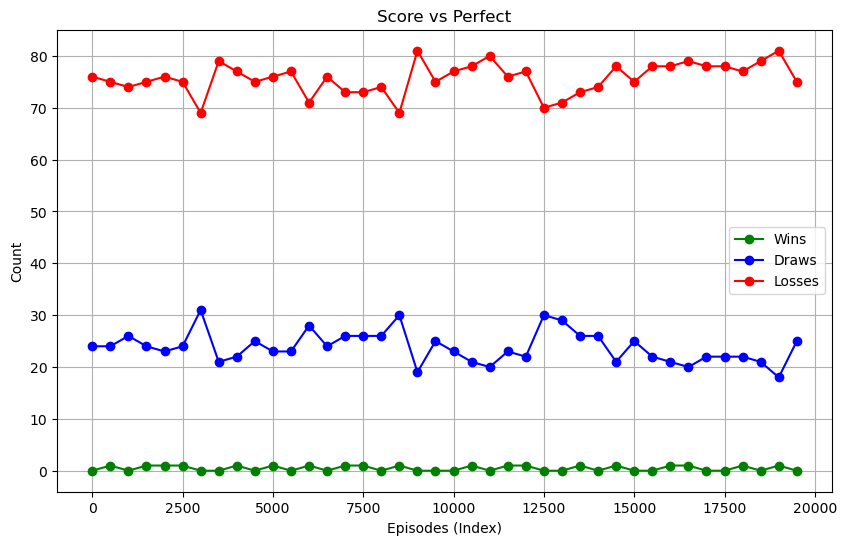

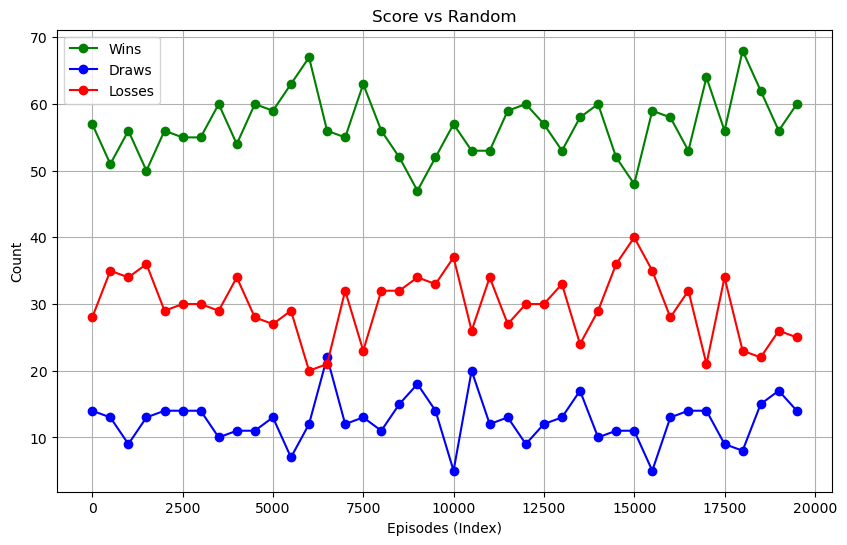

In [ ]:
def train_agent(episodes=10000, perfect_policy=perfect_strategy):
    # Agent plays as 1
    agent1 = QAgent(symbol=1, epsilon=0.1) 
    agent2 = QAgent(symbol=1, epsilon=0.1) 
    print("Training started...")
    score_vs_perfect = {}
    score_vs_random = {}

    start_time = time.perf_counter()

    for i in range(episodes):

        # Reset Game
        board = np.full((3, 3), 0, dtype=int)
        game_over = False


        # Game Loop
        while not game_over:
           #First Player
            move = agent1.choose_move(board)
            make_move(board, generate_cords(board, move), 1)

            if check_win(board, 1):
                agent1.update_q_table(board, reward=10, game_over=True)
                agent2.update_q_table(board, reward=-10, game_over=True)
                game_over = True
                break

            if check_draw(board):
                agent1.update_q_table(board, reward=1, game_over=True)
                agent2.update_q_table(board, reward=1, game_over=True)
                game_over = True
                break
            
            #Second Player
            move = agent2.choose_move(board)
            make_move(board, generate_cords(board, move), 2)

            if check_win(board, 2):
                # Punishment! The agent's last move allowed the opponent to win
                agent1.update_q_table(board, reward=-10, game_over=True)
                agent2.update_q_table(board, reward=10, game_over=True)

                game_over = True
                break
            
            # Check Draw again
            if check_draw(board):
                agent1.update_q_table(board, reward=2, game_over=True)
                agent2.update_q_table(board, reward=2, game_over=True)
                game_over = True
                break
            
            
            agent1.update_q_table(board, reward=0, game_over=False)
            agent2.update_q_table(board, reward=0, game_over=False)

        if i%500 == 0:
           if i % 500 == 0:
            # Run eval games
            random_score, perfect_score = play_evaluation_games(agent1, perfect_policy, 100)
            score_vs_perfect[i] = perfect_score
            score_vs_random[i] = random_score
            
            # calc time
            current_time = time.perf_counter()
            elapsed_time = current_time - start_time
            
            # Average time per episode so far
            avg_time_per_episode = elapsed_time / i
            
            # Calculate remaining
            remaining_episodes = episodes - i
            time_left = remaining_episodes * avg_time_per_episode
            
            # Format (HH:MM:SS)
            elapsed_str = str(datetime.timedelta(seconds=int(elapsed_time)))
            remaining_str = str(datetime.timedelta(seconds=int(time_left)))

            print(f"Episode {i}/{episodes} | Elapsed: {elapsed_str} | Remaining: {remaining_str}")


    print(f"Training Done.")

    #display graph thing
    plot_data(score_vs_perfect, "Score vs Perfect")
    plot_data(score_vs_random, "Score vs Random")

    return agent1

def plot_data(data, titel):
    indices = sorted(data.keys())
    wins = [data[i][0] for i in indices]
    draws = [data[i][1] for i in indices]
    losses = [data[i][2] for i in indices]

    plt.figure(figsize=(10, 6))

    plt.plot(indices, wins, label='Wins', color='green', marker='o')
    plt.plot(indices, draws, label='Draws', color='blue', marker='o')
    plt.plot(indices, losses, label='Losses', color='red', marker='o')

    plt.title(titel)
    plt.xlabel("Episodes (Index)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)

    plt.show()


def play_evaluation_games(agent, perfect_policy, game_count):
    win = 0
    draw = 0
    loss = 0
    
    random_score = ()
    perfect_score = ()

    for i in range(game_count * 2):

        # Reset Game
        board = np.full((3, 3), 0, dtype=int)
        game_over = False

        # Game Loop
        while not game_over:
           #First Player
            move = agent.choose_move(board)
            make_move(board, generate_cords(board, move), 1)

            if check_win(board, 1):
                game_over = True
                win += 1
                break

            if check_draw(board):
                draw += 1
                game_over = True
                break
            
            #Second Player
            if i < game_count:
                random_score = (win, draw, loss)
                opp_moves = available_moves(board)
                opp_move = random.choice(opp_moves) # Random opponent
                make_move(board, generate_cords(board, opp_move), 2)
            else:
                perfect_score = (win, draw, loss)
                opp_move = perfect_policy[tuple(board.reshape(9))]
                make_move(board, generate_cords(board, opp_move), 2)

            if check_win(board, 2):
                loss += 1
                game_over = True
                break
            
            # Check Draw again
            if check_draw(board):
                draw += 1
                game_over = True
                break
    perfect_score = (perfect_score[0] - random_score[0], perfect_score[1] - random_score[1], perfect_score[2] - random_score[2])
    return random_score, perfect_score

# --- EXECUTION ---
trained_agent = train_agent(20000)
# agent1 = QAgent(symbol=1, epsilon=0.1) 
# play_evaluation_games(agent1, 1)

## Game Player

In [112]:
def input_processor(move):
    move = move.split(' ')
    
    x = int(move[0])
    y = int(move[1])
    return (x,y)


opponent = "Human"
#choice = input("1 = Human. 2 = Random. 3 = Perfect Policy. 4 = Home Grown Policy 5 = Dont play")
choice = "5"
run_game = True
if choice == "5":
    run_game = False
while run_game:
    
    #First Player
    player = 1
    if choice == "1":
        opponent = "Human"
        make_move(board, input_processor(input("X players turn (input like this:1 2)")))
        draw_board(board, opponent)
        if check_win(board):
            run_game = False
            print("X player win")
            clear_board()
            continue
        if check_draw(board):
            run_game = False
            print("Draw")
            clear_board()
            continue
    elif choice == "2":
        opponent = "RNGesus"
        valid_play = False
        while not valid_play:
            x = random.randint(0, 2)
            y = random.randint(0, 2)
            if board[y][x] == 0:
                valid_play = True
                make_move(board, (x,y))
                draw_board(board, opponent)
                
        if check_win(board):
            run_game = False
            print("X player win")
            clear_board()
            continue            
        if check_draw(board):                
            run_game = False
            print("Draw")
            clear_board()
            continue

    
    #Second Player
    player = 2
    make_move(board, input_processor(input("O players turn (input like this:1 2)")))
    draw_board(board, opponent)
    if check_win(board):
        run_game = False
        print("O player win")
        clear_board()
    if check_draw(board):
        run_game = False
        print("Draw")
        clear_board()
        

